In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from skimage.io import imread
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import dataset_utils
import matplotlib.pyplot as plt
from time import time

## Config

In [40]:
images_size = (256, 128)
normalization_mean = [0.5, 0.5, 0.5]
normalization_std = [0.5, 0.5, 0.5]
dataset_name = "duke" # "duke" | "market"
dataset = dataset_utils.DukeMTMC
if dataset_name == "market":
    data_path = "../datasets/Market-1501-v15.09.15/"
elif dataset_name == "duke":
    data_path = "../datasets/DukeMTMC-reID/"
    
load_name = './model_weights/re-id_model/re-id-res2net_' + dataset_name + '_shared_conv_250_epochs.pth'
load_name = ''
save_name = './model_weights/re-id_model/re-id-res2net_' + dataset_name + '_check_metrics'
checkpoint_every = 5
batch_size = 16
dataloader_workers = 4
device = torch.device("cuda" if torch.cuda.device_count() > 1 else "cuda") if torch.cuda.is_available() else torch.device("cpu")
num_epochs = 31

## Res2Net

In [32]:
import math

class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            type: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)

        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale - 1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i == 0 or self.stype == 'stage':
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype == 'normal':
            out = torch.cat((out, spx[self.nums]), 1)
        elif self.scale != 1 and self.stype == 'stage':
            out = torch.cat((out, self.pool(spx[self.nums])), 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Res2Net(nn.Module):

    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d((7, 4), stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                            stype='stage', baseWidth=self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), x.size(1) * x.size(2), 1, 1) 

        return x

## Re-ID model

In [41]:
class ReIDModel(nn.Module):
    """Basic neural network model for reidentification. Based on Res2Net"""
    
    def __init__(self, Res2Net_model, person_number=751):
        super(ReIDModel, self).__init__()
        self.backbone = Res2Net_model
        self.conv_ident1 = nn.Conv2d(4096, person_number, 1)
        self.conv_ident2 = nn.Conv2d(4096, person_number, 1)
        self.conv_verif = nn.Conv2d(4096, person_number, 1)
        
        self.fc1 = nn.Linear(person_number, out_features=person_number)
        self.fc2 = nn.Linear(person_number, out_features=person_number)
        self.fc3 = nn.Linear(person_number, out_features=2)
        
    def forward(self, x, y):
        f1 = self.backbone(x)
        f2 = self.backbone(y)
        
        x = self.fc1(self.conv_ident1(f1).view(x.size(0), -1))
        y = self.fc2(self.conv_ident2(f2).view(y.size(0), -1))
    
        z = (f1 - f2) ** 2
        z = self.fc3(self.conv_verif(z).view(z.size(0), -1))
        
        return z, x, y
        

## Augmentations

In [42]:
from random import uniform, randint 
from math import sqrt
class RandomErasing(object):
    """Random Erasing"""
    
    def __init__(self, probability=0.4, er_area_min=0.02, er_area_max=0.4, asp_ratio=0.3,er_color=[150, 142, 129]):
        self.probability = probability
        self.erasing_area_min = er_area_min
        self.erasing_area_max = er_area_max
        self.aspect_ratio = asp_ratio
        self.erasing_color = er_color
        
    def __call__(self, img):
        if uniform(0, 1) <= self.probability:
            target_area = uniform(self.erasing_area_min, self.erasing_area_max) * img.shape[1] * img.shape[2]
            aspect_ratio = uniform(self.aspect_ratio, 1 / self.aspect_ratio)
            
            h = round(sqrt(target_area * aspect_ratio))
            w = round(sqrt(target_area / aspect_ratio))
            
            if h < img.shape[1] and w < img.shape[2]:
                top_left = (randint(0, img.shape[1] - h), randint(0, img.shape[2] - w))
                for i in range(3):
                    img[i, top_left[0]:top_left[0] + h, top_left[1]:top_left[1] + w] = self.erasing_color[i] / 255
        return img

In [43]:
transform_train = transforms.Compose([
    transforms.Resize(images_size),
    transforms.RandomCrop((246, 128)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    RandomErasing()
])

transform_val = transforms.Compose([
    transforms.Resize(images_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

## Load data

In [44]:
train_data = dataset(data_path, "Train", transform_train)

<IPython.core.display.Javascript object>


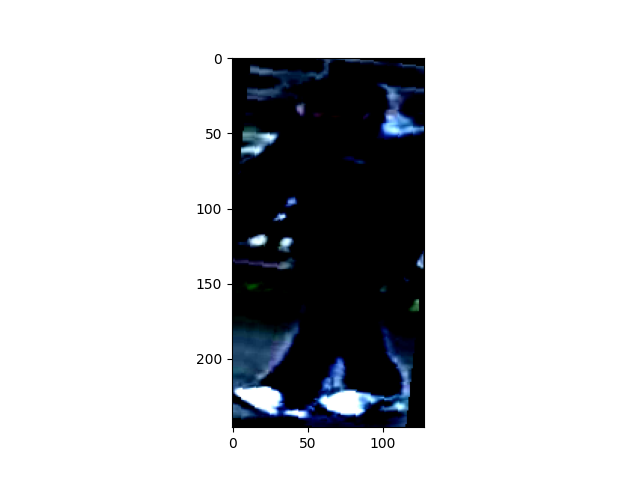

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [49]:

plt.imshow(train_data[0]['image'].permute(1, 2, 0))

## Load models

In [50]:
path = './model_weights/res2net50_26w_4s-06e79181.pth'
model_base = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth = 26, scale = 4)
model_base.load_state_dict(torch.load(path))
model = nn.DataParallel(ReIDModel(model_base, train_data.label_count))

if load_name != "":
    model.load_state_dict(torch.load(load_name))
model = model.to(device)

In [51]:
model.device_ids

[0]

## Loss Function, Optimizer and Warmup Learning Rate

In [52]:
from scheduler import GradualWarmupScheduler

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
scheduler_lr_red = torch.optim.lr_scheduler.StepLR(optimizer, 40, 0.1)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=10, total_epoch=5, after_scheduler=scheduler_lr_red)

## Train

In [53]:


from tqdm.notebook import tqdm

for epoch in range(num_epochs):
    
    loss_list = []
    acc_verification_list = []
    acc_first_id_list = []
    acc_second_id_list = []
    acc_first_id_val_list = [1]
    acc_second_id_val_list = [1]
    
    for i in tqdm(range(0, len(train_data), batch_size)):
        optimizer.zero_grad()
        
        images_first = torch.zeros((batch_size, 3, 246, 128), dtype = torch.float32, device = device)
        images_second = torch.zeros((batch_size, 3, 246, 128), dtype = torch.float32, device = device)
        persons_id_first = torch.zeros((batch_size, ), dtype = torch.long, device = device)
        persons_id_second = torch.zeros((batch_size, ), dtype = torch.long, device = device)
        verification = torch.zeros(batch_size, dtype=torch.long, device=device)
        
        for j, k in enumerate(range(i, i + batch_size)):
            k = torch.randint(0, len(train_data), (1,)).item()
            first_image = train_data[k]
            
            images_first[j] = first_image["image"]
            persons_id_first[j] = first_image["person_id"]
            
            r = torch.rand((1, )).item()

            if r <= 0.4:
                verification[j] = 1
                idx = train_data.get_random_class_image_idx(persons_id_first[j].item(), True)
            else:
                idx = train_data.get_random_class_image_idx(persons_id_first[j].item(), False)
                
            second_image = train_data[idx]
            images_second[j] = second_image["image"]
            persons_id_second[j] = second_image["person_id"]
            
            
        output = model(images_first, images_second)

        loss_verification = F.cross_entropy(output[0], verification)
        loss_first_id = F.cross_entropy(output[1], persons_id_first)
        loss_second_id = F.cross_entropy(output[2], persons_id_second)
        
        loss = loss_verification + 0.5 * (loss_first_id + loss_second_id)

        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        
        predicted = torch.argmax(output[0], 1)
        correct = (predicted == verification).sum().item()
        acc_verification_list.append(correct / verification.size()[0])
        
        predicted = torch.argmax(output[1], 1)
        correct = (predicted == persons_id_first).sum().item()
        acc_first_id_list.append(correct / persons_id_first.size()[0])
        
        predicted = torch.argmax(output[2], 1)
        correct = (predicted == persons_id_second).sum().item()
        acc_second_id_list.append(correct / persons_id_second.size()[0])
        
    scheduler_warmup.step()
        
    if epoch % checkpoint_every == 0 and epoch != 0:
        torch.save(model.state_dict(), save_name + "_" + str(epoch) + "_epochs.pth")
    print('{}\'s epoch is over, Loss: {:.4f}, Verification Accuracy: {:.6f}%, First Person ID Accuracy: {:.6f}%, Second Person ID Accuracy: {:.6f}%, First Person ID Val Accuracy: {:.6f}%, Second Person ID Val Accuracy: {:.6f}%\n'
          .format(epoch + 1, sum(loss_list) / float(len(loss_list)), 
                  sum(acc_verification_list) / float(len(acc_verification_list)), 
                  sum(acc_first_id_list) / float(len(acc_first_id_list)),
                  sum(acc_second_id_list) / float(len(acc_second_id_list)),
                  sum(acc_first_id_val_list) / float(len(acc_first_id_val_list)),
                  sum(acc_second_id_val_list) / float(len(acc_second_id_val_list))))


1's epoch is over, Loss: 5.7707, Verification Accuracy: 0.764944%, First Person ID Accuracy: 0.108120%, Second Person ID Accuracy: 0.061048%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%




2's epoch is over, Loss: 3.5264, Verification Accuracy: 0.866953%, First Person ID Accuracy: 0.311229%, Second Person ID Accuracy: 0.269603%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%




4's epoch is over, Loss: 1.5568, Verification Accuracy: 0.922132%, First Person ID Accuracy: 0.660636%, Second Person ID Accuracy: 0.650048%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




8's epoch is over, Loss: 0.5293, Verification Accuracy: 0.955046%, First Person ID Accuracy: 0.884862%, Second Person ID Accuracy: 0.890912%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




12's epoch is over, Loss: 0.2921, Verification Accuracy: 0.966602%, First Person ID Accuracy: 0.943792%, Second Person ID Accuracy: 0.940525%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%




13's epoch is over, Loss: 0.2640, Verification Accuracy: 0.967389%, First Person ID Accuracy: 0.949238%, Second Person ID Accuracy: 0.952021%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




16's epoch is over, Loss: 0.2186, Verification Accuracy: 0.971684%, First Person ID Accuracy: 0.960370%, Second Person ID Accuracy: 0.960249%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%




17's epoch is over, Loss: 0.1993, Verification Accuracy: 0.972592%, First Person ID Accuracy: 0.961762%, Second Person ID Accuracy: 0.966179%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




20's epoch is over, Loss: 0.1655, Verification Accuracy: 0.974528%, First Person ID Accuracy: 0.969869%, Second Person ID Accuracy: 0.972229%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%




21's epoch is over, Loss: 0.1571, Verification Accuracy: 0.978703%, First Person ID Accuracy: 0.974528%, Second Person ID Accuracy: 0.969809%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




24's epoch is over, Loss: 0.1362, Verification Accuracy: 0.978521%, First Person ID Accuracy: 0.977674%, Second Person ID Accuracy: 0.976646%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%




25's epoch is over, Loss: 0.1346, Verification Accuracy: 0.981546%, First Person ID Accuracy: 0.976948%, Second Person ID Accuracy: 0.976041%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




29's epoch is over, Loss: 0.1134, Verification Accuracy: 0.981244%, First Person ID Accuracy: 0.983241%, Second Person ID Accuracy: 0.982394%, First Person ID Val Accuracy: 1.000000%, Second Person ID Val Accuracy: 1.000000%



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
torch.save(model.state_dict(), save_name)

## Testing

In [68]:
load_name = './model_weights/re-id_model/re-id-res2net_' + dataset_name + '_check_metrics_5_epochs.pth'
path = load_name
model.load_state_dict(torch.load(path, map_location=torch.device('cuda')))

<All keys matched successfully>

In [69]:
model_base.parameters = model.module.backbone.parameters
model_base = model_base.to(torch.device('cuda'))

In [70]:
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

#market_test = Market1501('./datasets/Market-1501-v15.09.15', dataset_type='Test', transform=transform)
duke_test = dataset(data_path, dataset_type='Test', transform=transform)
dataloader_test = DataLoader(duke_test, batch_size=32, shuffle=False)

### Creating Gallery Descriptors

In [71]:
from tqdm.notebook import tqdm

gallery = []

model_base.eval()
with torch.no_grad():
    for batch in tqdm(dataloader_test):
        batch['image'] = batch['image'].to(torch.device('cuda'))
        output = model_base(batch['image'])
        for i in range(batch['image'].size()[0]):
            gallery.append([output[i].view(4096).cpu().numpy(), 
                            batch['person_id'][i].cpu().numpy(), 
                            batch['camera_id'][i].cpu().numpy()])
            
np.save(data_path + 'gallery_descriptors.npy', np.asarray(gallery))

In [72]:
gallery = np.load(data_path + 'gallery_descriptors.npy', allow_pickle=True)

### Testing on Query Images

In [73]:
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

#market_query = Market1501('./datasets/Market-1501-v15.09.15', dataset_type='Query', transform=transform)
duke_query = dataset(data_path, dataset_type='Query', transform=transform)
dataloader_query = DataLoader(duke_query, batch_size=1, shuffle=False)

In [74]:
duke_query.label_count

702

#### Define Cos Similarity

In [75]:
cos = nn.CosineSimilarity(dim=0, eps=1e-8)

In [76]:
from tqdm.notebook import tqdm

j = 0
cos_dist = np.zeros((dataloader_query.__len__(), duke_test.__len__() + 1, 3))

model_base.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader_query)):
        batch['image'] = batch['image'].to(torch.device('cuda'))
        output = model_base(batch['image'])
        output = output.view(1, 4096)
        
        for j, gallery_descriptor in enumerate(gallery):
            cos_dist[i, j, 0], cos_dist[i, j, 1], cos_dist[i, j, 2] = gallery_descriptor[1], gallery_descriptor[2], cos(output[0].to(torch.device('cpu')), 
                                                                                                       torch.from_numpy(gallery_descriptor[0])).item()
        cos_dist[i, j + 1, 0] = batch['person_id'].item()
        cos_dist[i, j + 1, 1] = batch['camera_id'].item()
        
np.save(data_path + 'cos_dist.npy', np.asarray(cos_dist))

In [77]:
cos_dist = np.load(data_path + 'cos_dist.npy', allow_pickle=True)

#### Rank-1 Metric

In [78]:
correct = 0

for element in cos_dist:
    person_id = element[-1, 0]
    camera_id = element[-1, 1]
    
    element = np.delete(element, np.where(element[:, 1] == camera_id), axis=0)
    
    if element[element[:,-1].argsort()][-1][0] == person_id:
        correct += 1

rank_1 = correct / cos_dist.shape[0]
print(rank_1 * 100)

68.35727109515261


#### mAP Metric (not interpolated)

In [79]:
tp_fn = []

for element in cos_dist:
    person_id = element[-1, 0]
    camera_id = element[-1, 1]
    
    tp_fn.append(np.where(np.logical_and(element[:, 0] == person_id, element[:, 1] != camera_id))[0].shape[0])

In [80]:
from tqdm.notebook import tqdm

i = 0
p_r_dots = []

for element in tqdm(cos_dist):
    person_id = element[-1, 0]
    camera_id = element[-1, 1]
    
    element = np.delete(element, np.where(element[:, 1] == camera_id), axis=0)
    element = element[element[:,-1].argsort()]
    
    tmp = np.zeros((element.shape[0], 2))
    tmp[np.argwhere(element[:, 0] == person_id), 0] = 1
    tmp[:, 1] = element[:, 2]
    p_r_dots.append(tmp)
    
p_r_dots = np.asarray(p_r_dots)

In [81]:
from sklearn.metrics import average_precision_score

map_sum = 0
for el in p_r_dots:
    y_true, y_score = el[:, 0], el[:, 1]
    map_sum += average_precision_score(y_true, y_score)
    
mAP = map_sum / p_r_dots.shape[0]
print(mAP * 100)

45.565970756527264


#### mAP Metric (interpolated)

In [ ]:
from tqdm.notebook import tqdm

i = 0
p_r_dots = []

for element in tqdm(cos_dist):
    person_id = element[-1, 0]
    camera_id = element[-1, 1]
    
    element = np.delete(element, np.where(element[:, 1] == camera_id), axis=0)
    element = element[element[:,-1].argsort()]
    
    tmp = []
    old_confidence = 0
    step = 1
    for j, confidence in enumerate(element[:, 2]):
        if j == 0:
            tp = np.where(np.logical_and(element[:, 0] == person_id, element[:, 2] >= confidence))[0].shape[0]
            fp = np.where(np.logical_and(element[:, 0] != person_id, element[:, 2] >= confidence))[0].shape[0]
        else:
            if old_confidence < confidence:
                if element[j - 1, 0] == person_id:
                    tp -= step
                else:
                    fp -= step
                step = 1
            else:
                step += 1
                    
        old_confidence = confidence
        tmp.append((tp / tp_fn[i], tp / (tp + fp), confidence))
        

    p_r_dots.append(np.asarray(tmp))
    i += 1
    
p_r_dots = np.asarray(p_r_dots)

In [ ]:
import matplotlib.pyplot as plt
for dots in p_r_dots:
    plt.plot(dots[:, 0], dots[:, 2])
    break

In [ ]:
map_sum = 0

for dots in p_r_dots[0:,]:
    recallValues = np.arange(0, 1.1, 0.1)
    recallValues = list(recallValues[::-1])
    precision = []
    
    dots = sorted(dots, key=lambda x: x[0])
    dots_np = np.zeros((len(dots), 2))
    
    for i, dot in enumerate(dots):
        dots_np[i][0], dots_np[i][1] = dot[0], dot[1]
        
    for r in recallValues:
        argGreaterRecalls = np.argwhere(dots_np[:, 0] >= r)
        if argGreaterRecalls.size != 0:
            precision.append(max(dots_np[argGreaterRecalls.min():, 1]))

    map_sum += (sum(precision)) / 11
    
mAP = map_sum / p_r_dots.shape[0]
print(mAP * 100)